# Emulating near surface temperature on land with MESMER
Using calibrated parameters, we can emulate a large ensemble of realisations of near surface temperature with MESMER. To calibrate MESMER, follow the Tutorials on calibrating either on one or multiple scenarios in the Tutorial section. 
Here, we will emulate realisation for two predicting global mean temperature trajectories at once. 

In [1]:
import pathlib

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from filefisher import FileFinder

import mesmer
from mesmer.core.datatree import map_over_datasets

### Load forcing data
One can use any global mean temperature trajectory to draw gridded realisations. For this example we want to create emulations for SSP1-2.6 and SSP5-8.5 to compare the emulations to the actual ESM output. Here we concatenate historical and future runs to create a continuous timeseries.

In [2]:
model = "IPSL-CM6A-LR"
scenarios = ["ssp126", "ssp585"]

# some configuration parameters
THRESHOLD_LAND = 1 / 3

REFERENCE_PERIOD = slice("1850", "1900")

HIST_PERIOD = slice("1850", "2014")

In [3]:
cmip_path = mesmer.example_data.cmip6_ng_path(relative=True)

CMIP_FILEFINDER = FileFinder(
    path_pattern=cmip_path / "{variable}/{time_res}/{resolution}",
    file_pattern="{variable}_{time_res}_{model}_{scenario}_{member}_{resolution}.nc",
)

fc_scens = CMIP_FILEFINDER.find_files(
    variable="tas", scenario=scenarios, model=model, resolution="g025", time_res="ann"
)

members = fc_scens.df.member.unique()

fc_hist = CMIP_FILEFINDER.find_files(
    variable="tas",
    scenario="historical",
    model=model,
    resolution="g025",
    time_res="ann",
    member=members,
)

In [4]:
def _get_hist(meta, fc_hist):

    meta_hist = meta | {"scenario": "historical"}

    fc = fc_hist.search(**meta_hist)

    if len(fc) == 0:
        raise FileNotFoundError("no hist file found")
    if len(fc) != 1:
        raise ValueError("more than one hist file found")

    fN, meta_hist = fc[0]

    return fN, meta_hist


def load_hist(meta, fc_hist):
    fN, __ = _get_hist(meta, fc_hist)

    time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)
    return xr.open_dataset(fN, decode_times=time_coder)


def load_hist_scen_continuous(fc_hist, fc_scens):
    dt = xr.DataTree()
    for scen in fc_scens.df.scenario.unique():
        files = fc_scens.search(scenario=scen)

        members = []

        time_coder = xr.coders.CFDatetimeCoder(use_cftime=True)

        for fN, meta in files.items():

            try:
                hist = load_hist(meta, fc_hist)
            except FileNotFoundError:
                continue

            proj = xr.open_dataset(fN, decode_times=time_coder)

            ds = xr.combine_by_coords(
                [hist, proj],
                combine_attrs="override",
                data_vars="minimal",
                compat="override",
                coords="minimal",
            )

            ds = ds.drop_vars(("height", "time_bnds", "file_qf"), errors="ignore")

            # assign member-ID as coordinate
            ds = ds.assign_coords({"member": meta["member"]})

            members.append(ds)

        # create a Dataset that holds each member along the member dimension
        scen_data = xr.concat(members, dim="member")
        # put the scenario dataset into the DataTree
        dt[scen] = xr.DataTree(scen_data)
    return dt

In [5]:
tas = load_hist_scen_continuous(fc_hist, fc_scens)
ref = tas.sel(time=REFERENCE_PERIOD).mean("time")
tas_anom = tas - ref
tas_globmean = mesmer.weighted.global_mean(tas_anom)

tas_globmean_ensmean = tas_globmean.mean(dim="member")
tas_globmean_forcing = mesmer.stats.lowess(
    tas_globmean_ensmean,
    dim="time",
    n_steps=30,
    use_coords=False,
)
time = tas_globmean_forcing["ssp126"].time

### Load the parameters
We load the parameters that were calibrated on historical, SSP1-2.6 and SSP5-8.5 data. But one can also use parameters that were calibrated on only one scenario. For more details on the benefits of calibrating on multiple scenarios, please refer to [Beusch et al. 2022](https://doi.org/10.5194/gmd-15-2085-2022).

In [6]:
# find the parameters - use same relative path as above
data_path = pathlib.Path("./output/calibrated_parameters/")

PARAM_FILEFINDER = FileFinder(
    path_pattern=data_path,
    file_pattern="params_{module}_{esm}_{scen}.nc",
)
scen_str = "-".join(scenarios)

In [7]:
all_modules = [
    "volcanic",
    "global-variability",
    "local-trends",
    "local-variability",
    "covariance",
]
param_files = PARAM_FILEFINDER.find_files(module=all_modules, esm=model, scen=scen_str)

params = xr.DataTree()

for module in all_modules:
    params[module] = xr.DataTree(
        xr.open_dataset(param_files.search(module=module).paths.pop()), name=module
    )

### Define seeds for global and local variability 
If we want reproducible results we need to set a seed for the random samples of global and local variability. Here, we set the seed to a chosen number, but for automated generation of seeds i.e. for several ESM we recommend using the `secrets` from the standard library. 
Then you would generate a seed using:

```python
import secrets

xr.Dataset(data_vars={"seed": secrets.randbits(64)})
```

In [8]:
seed_global_variability = xr.DataTree.from_dict(
    {
        "ssp126": xr.Dataset(data_vars={"seed": 981}),
        "ssp585": xr.Dataset(data_vars={"seed": 314}),
    }
)
seed_local_variability = xr.DataTree.from_dict(
    {
        "ssp126": xr.Dataset(data_vars={"seed": 272}),
        "ssp585": xr.Dataset(data_vars={"seed": 42}),
    }
)

### Make emulations

In [9]:
# some settings
n_realisations = 10

buffer_global_variability = 50
buffer_local_variability = 20

#### 1. Adding the volcanic influence to the smooth global mean forcing
This is optional, depending on if you want to reproduce the past accurately. This is necessary when we want to evaluate the performance of our emulator on ESM or observation data but might not be necessary for more abstract research questions.

In [10]:
tas_globmean_forcing = mesmer.volc.superimpose_volcanic_influence(
    tas_globmean_forcing,
    params["volcanic"].ds,
    hist_period=HIST_PERIOD,
)

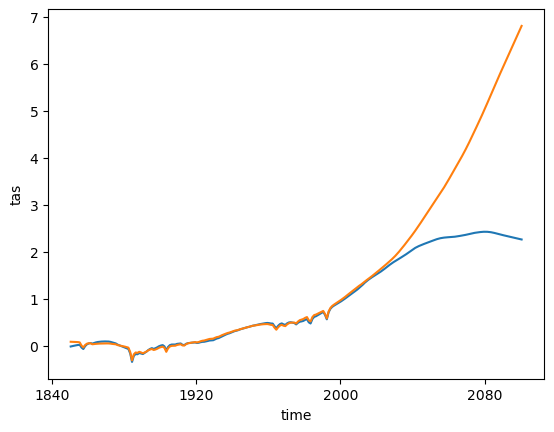

In [11]:
tas_globmean_forcing["ssp126"].to_dataset().tas.plot()
tas_globmean_forcing["ssp585"].to_dataset().tas.plot()

#### 2. Compute global variabilty 
Draw samples from a AR process with the calibrated parameters.

In [12]:
global_variability = mesmer.stats.draw_auto_regression_uncorrelated(
    params["global-variability"].ds,
    realisation=n_realisations,
    time=time,
    seed=seed_global_variability,
    buffer=buffer_global_variability,
)
global_variability = map_over_datasets(
    lambda ds: ds.rename({"samples": "tas_resids"}), global_variability
)

#### 3. Compute local forced response
Apply linear regression using the global mean forcing and the global variability as predictors. Optionally, you can also add other variables to the predictors like ocean heat content or squared global mean temperature.

In [13]:
predictors = mesmer.datatree.merge([tas_globmean_forcing, global_variability])

lr = mesmer.stats.LinearRegression()
lr.params = params["local-trends"].ds

# uses ``exclude`` to split the linear response
local_forced_response = lr.predict(predictors, exclude={"tas_resids"})

# local variability part driven by global variabilty
local_variability_from_global_var = lr.predict(predictors, exclude={"tas", "intercept"})

#### 4. Compute local variability
We compute the local variability by applying an AR(1) process to ensure consistency in time and adding spatially correlated innovations at each time step to get spatially coherent random samples at each gridpoint.

In [14]:
local_variability = mesmer.stats.draw_auto_regression_correlated(
    params["local-variability"].ds,
    params["covariance"].localized_covariance,
    time=time,
    realisation=n_realisations,
    seed=seed_local_variability,
    buffer=buffer_local_variability,
)
local_variability = map_over_datasets(
    lambda ds: ds.rename({"samples": "prediction"}), local_variability
)

#### 5. Add everything together

In [23]:
local_variability_total = local_variability_from_global_var + local_variability
emulations = local_forced_response + local_variability_total
emulations = map_over_datasets(
    lambda ds: ds.rename({"prediction": "tas"}),
    emulations,
)

### Saving emulations
We recommend saving the emulations together with the seeds used for emulating.

In [24]:
for scen in emulations:
    local_seed = seed_local_variability[scen].seed.rename("seed_local_variability")
    global_seed = seed_global_variability[scen].seed.rename("seed_global_variability")
    emulations[scen] = xr.DataTree(
        xr.merge([emulations[scen].ds, local_seed, global_seed])
    )

emu_path = "./output/emulations/"
emulations.to_netcdf(emu_path + f"tas_emulations_{model}_ssp126-ssp585.nc")

## Some example plots

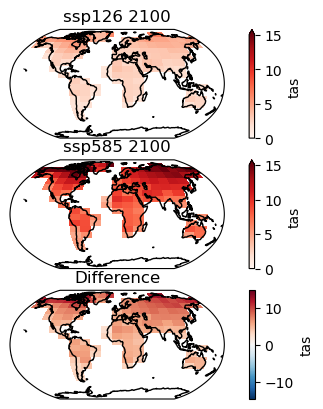

In [ ]:
# maps of the means over all realisations for the two scenarios and their difference in 2100
grid_orig = tas_anom["ssp126"].ds[["lat", "lon"]]
spatial_emu_126 = mesmer.grid.unstack_lat_lon_and_align(
    emulations["ssp126"].tas, grid_orig
)
spatial_emu_585 = mesmer.grid.unstack_lat_lon_and_align(
    emulations["ssp585"].tas, grid_orig
)

f, axs = plt.subplots(3, 1, subplot_kw={"projection": ccrs.Robinson()})

opt = dict(cmap="Reds", transform=ccrs.PlateCarree(), vmin=0, vmax=15, extend="max")
spatial_emu_126.mean("realisation").sel(time="2100").plot(ax=axs[0], **opt)
spatial_emu_585.mean("realisation").sel(time="2100").plot(ax=axs[1], **opt)

diff = spatial_emu_585 - spatial_emu_126
diff.mean("realisation").sel(time="2100").plot(
    ax=axs[2], cmap="RdBu_r", transform=ccrs.PlateCarree(), center=0
)

axs[0].set_title("ssp126 2100")
axs[1].set_title("ssp585 2100")
axs[2].set_title("Difference")

for ax in axs:
    ax.coastlines()
    ax.set_global()

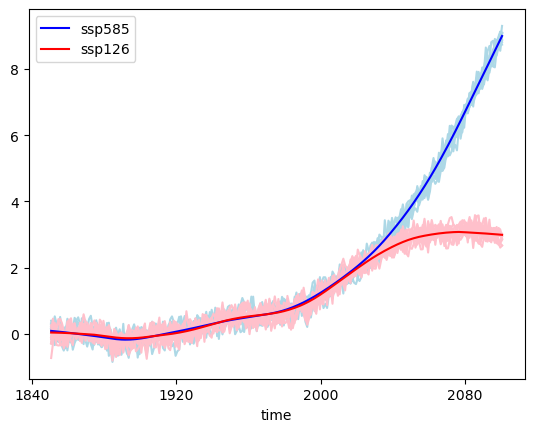

In [26]:
# plot global land means
globmean_126 = mesmer.weighted.global_mean(spatial_emu_126)
globmean_585 = mesmer.weighted.global_mean(spatial_emu_585)

globmean_126_smoothed = mesmer.stats.lowess(
    globmean_126.mean("realisation"), dim="time", n_steps=50, use_coords=False
)
globmean_585_smoothed = mesmer.stats.lowess(
    globmean_585.mean("realisation"), dim="time", n_steps=50, use_coords=False
)

f, ax = plt.subplots()
globmean_585.plot.line(x="time", ax=ax, add_legend=False, color="lightblue")
globmean_126.plot.line(x="time", ax=ax, add_legend=False, color="pink")

globmean_585_smoothed.plot.line(x="time", ax=ax, color="blue", label="ssp585")
globmean_126_smoothed.plot.line(x="time", ax=ax, color="red", label="ssp126")

plt.legend()
plt.show()

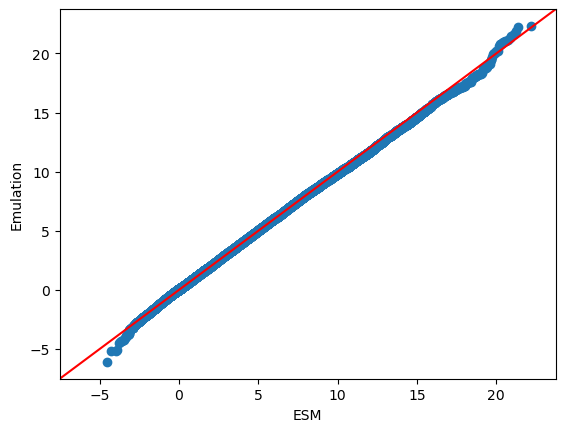

In [ ]:
# qq plot between ESM and emulation
esm_ssp585 = tas_anom["ssp585"].ds


def mask(ds, threshold_land):
    ds = mesmer.mask.mask_ocean_fraction(ds, threshold_land)
    ds = mesmer.mask.mask_antarctica(ds)
    return ds


esm_ssp585 = mask(esm_ssp585, THRESHOLD_LAND)

esm_ssp585 = esm_ssp585.tas.stack(sample=("time", "lat", "lon", "member"))
emu_ssp585 = spatial_emu_585.stack(sample=("time", "lat", "lon", "realisation"))

import statsmodels.api as sm

sm.qqplot_2samples(esm_ssp585, emu_ssp585, line="45")
plt.xlabel("ESM")
plt.ylabel("Emulation")
plt.show()